In [187]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from scipy import stats
import statistics
import thinkdsp

In [188]:
# Read file
def read_lab_file(file_name):
    with open(file_name, 'r') as f:
        lines = f.readlines()
    lines = lines[:-2]
    result = []
    for line in lines :
        temp = line.split("\t")
        result.append((temp[0],temp[1],temp[2].strip()))
    return result

def process_lab_file(wav_file, lab_file):

    file_result = read_lab_file(lab_file)
    result = []
    for res in file_result:
        seg_limits = np.asarray([res[0], res[1]], dtype=np.float64)
        if res[2] == "sil":
            result.append(seg_limits) 

    return np.array(result)

In [189]:
# Short term features

def zero_crossing_rate(frame):
    """Computes zero crossing rate of frame"""
    count_zero = np.sum(np.abs(np.diff(np.sign(frame)))) / 2
    return np.float64(count_zero)

def energy(frame):
    """Computes signal energy of frame"""
    return np.sum(frame ** 2)

def sta(vu_frame):
    """Compute short-time average (often called running average)"""
    count = len(vu_frame)
    return np.sum(vu_frame) / np.float64(count)

def lf(frame, sampling_rate):
    """Compute low-band over full-band ratio of energy"""
    # Create wave proviced amplitude at given time and sampling rate
    temp_sig = thinkdsp.Wave(ys=frame, framerate=sampling_rate)
    sp = temp_sig.make_spectrum()
    # Remove frequency component that have frequency value > 1000Hz
    sp.low_pass(1000)
    filter_wave = sp.make_wave()
    return energy(filter_wave.ys)/energy(frame)

In [190]:
def feature_extraction(signal, sampling_rate, window, step):
    """
    This function implements the short-term windowing process.
    For each short-term window a set of features is extracted.
    This results to a sequence of feature vectors, stored in a np matrix.
    ARGUMENTS
        signal:         the input signal samples
        sampling_rate:  the sampling freq (in Hz)
        window:         the short-term window size (in samples)
        step:           the short-term window step (in samples)
    RETURNS
        features (numpy.ndarray):        contains features
                                         (n_feats x numOfShortTermWindows)
        feature_names (python list):     contains feature names
                                         (n_feats x numOfShortTermWindows)
    """

    window = int(window)
    step = int(step)

    number_of_samples = len(signal)  # total number of samples
    current_position = 0
    count_fr = 0

    # define list of feature names
    feature_names = ["zcr", "energy", "lf"]

    features = []
    # for each short-term window to end of signal
    while current_position + window - 1 < number_of_samples:
        count_fr += 1
        # get current window
        x = signal[current_position:current_position + window]
        # update window position
        current_position = current_position + step

        feature_vector = np.zeros((3,1))

        # zero crossing rate
        feature_vector[0] = zero_crossing_rate(x)
        # short-term energy
        feature_vector[1] = energy(x)
        # Low-band over Full-band
        feature_vector[2] = lf(x, sampling_rate)

        features.append(feature_vector)
   
    features = np.concatenate(features, 1)
    
    return features, feature_names

In [191]:
def segment_limits(data, threshold, st_step, last_frames):
    """Get the time segment where elements in range (>=2) is greater than threshold"""

    max_indices = np.where(data < threshold)[0]

    # get the indices of the frames that satisfy the thresholding
    index = 0
    seg_limits = []
    time_clusters = []

    while index < len(max_indices):
        # for each of the detected onset indices
        cur_cluster = [max_indices[index]]
        if index == len(max_indices)-1:
            cur_cluster.append(last_frames)
            break
        while max_indices[index+1] - cur_cluster[-1] <= 2:
            cur_cluster.append(max_indices[index+1])
            index += 1
            if abs(max_indices[index] - last_frames) <= 2:
                cur_cluster.append(last_frames)
            if index == len(max_indices)-1:
                break
        index += 1
        time_clusters.append(cur_cluster)
        seg_limits.append([cur_cluster[0] * st_step,
                           cur_cluster[-1] * st_step])
    return seg_limits 

In [192]:
def histogram_based_method(st_energy, user_defined_value, pos_1, pos_2):
    """ Calculate the threshold based on histogram """
    w = user_defined_value
    y, x = np.histogram(st_energy, bins=len(st_energy)) 

    indexes = sig.find_peaks(y)[0]

    max1 = x[indexes[pos_1]]
    max2 = x[indexes[pos_2]]
    # max1 = y[0]
    # max_x_1 = 0
    # max2 = -1
    # max_x_2 = -1

    # for i in range(len(y)):
    #     if(y[i] > max1):
    #         max2 = max1
    #         max_x_2 = max_x_1
    #         max1 = y[i]
    #         max_x_1 = i
    #     if (y[i] < max1 and y[i] > max2):
    #         max2 = y[i]
    #         max_x_2 = i
    
    # max1 = x[max_x_1]
    # max2 = x[max_x_2]

    T = np.float64(w * max1 + max2)/np.float64(w + 1)
    return T

In [193]:
def silence_discrimination(signal, sampling_rate, st_win, st_step):
    """
    ARGUMENTS:
         - signal:                the input audio signal
         - sampling_rate:               sampling freq
         - st_win, st_step:    window size and step in seconds
    """

    # Feature extraction
    st_feats, _ =   feature_extraction(signal, sampling_rate,
                                         st_win * sampling_rate,
                                         st_step * sampling_rate)
    
    st_energy = st_feats[1, :]
    
    ste_threshold = histogram_based_method(st_energy[:], 0.3, 0, 1)

    seg_limits = segment_limits(st_energy[:], ste_threshold, st_step, round(np.float64(len(signal))/(st_win * sampling_rate)))
    # Remove very small segments:
    min_duration = 0.25
    seg_limits_2 = []
    for s_lim in seg_limits:
        if s_lim[1] - s_lim[0] > min_duration:
            seg_limits_2.append(s_lim)
    seg_limits = seg_limits_2
    return seg_limits 

In [194]:
def draw_result(wave_file_name, lab_file_name, title):
    print(title)
    # Create wave
    wave = thinkdsp.read_wave(filename=wave_file_name)

    # Make the curve smooth
    n =  9 # the larger n is, the smoother curve will be
    b = [1.0 / n] * n
    a = 1
    yy = sig.lfilter(b,a,wave.ys)

    silence_segment = silence_discrimination(yy, wave.framerate, 0.020, 0.020)
    result_seg_limits = process_lab_file(wave_file_name,lab_file_name)
    print(silence_segment)
    print("sil result", result_seg_limits)
    
    fig, axs = plt.subplots(3, figsize=(20,15))
    fig.tight_layout(h_pad=3)

    # Axis 0 is for speech signal
    axs[0].plot(wave.ts, wave.ys)
    axs[0].set_xlabel("Time (s)")
    axs[0].set_ylabel("Amplitude")
    axs[0].set_title("Speech signal " + title)

    # Speech/Silence discriminator
    axs[1].plot(wave.ts, wave.ys)
    axs[1].set_xlabel("Time (s)")
    axs[1].set_ylabel("Amplitude")
    for s_lim in silence_segment:
        axs[1].axvline(x=s_lim[0], color='orange')
        axs[1].axvline(x=s_lim[1], color='orange')

    axs[2].plot(wave.ts, wave.ys)
    axs[2].set_xlabel("Time (s)")
    axs[2].set_ylabel("Amplitude")
    axs[2].set_title("Ideal discriminator")
    for s_lim in result_seg_limits:
        axs[2].axvline(x=s_lim[0], color='red')
        axs[2].axvline(x=s_lim[1], color='red')

Studio F1
[[0.0, 0.66], [2.14, 2.86]]
sil result [[0.   0.68]
 [2.15 2.86]]
Phone M1
[[0.0, 0.46], [3.52, 4.16]]
sil result [[0.   0.46]
 [3.52 4.15]]
Studio M1
[[0.0, 0.9], [2.02, 2.74]]
sil result [[0.   0.87]
 [2.06 2.73]]
Phone F1
[[0.0, 0.52], [1.6, 1.9000000000000001], [2.74, 3.24]]
sil result [[0.   0.53]
 [2.75 3.23]]


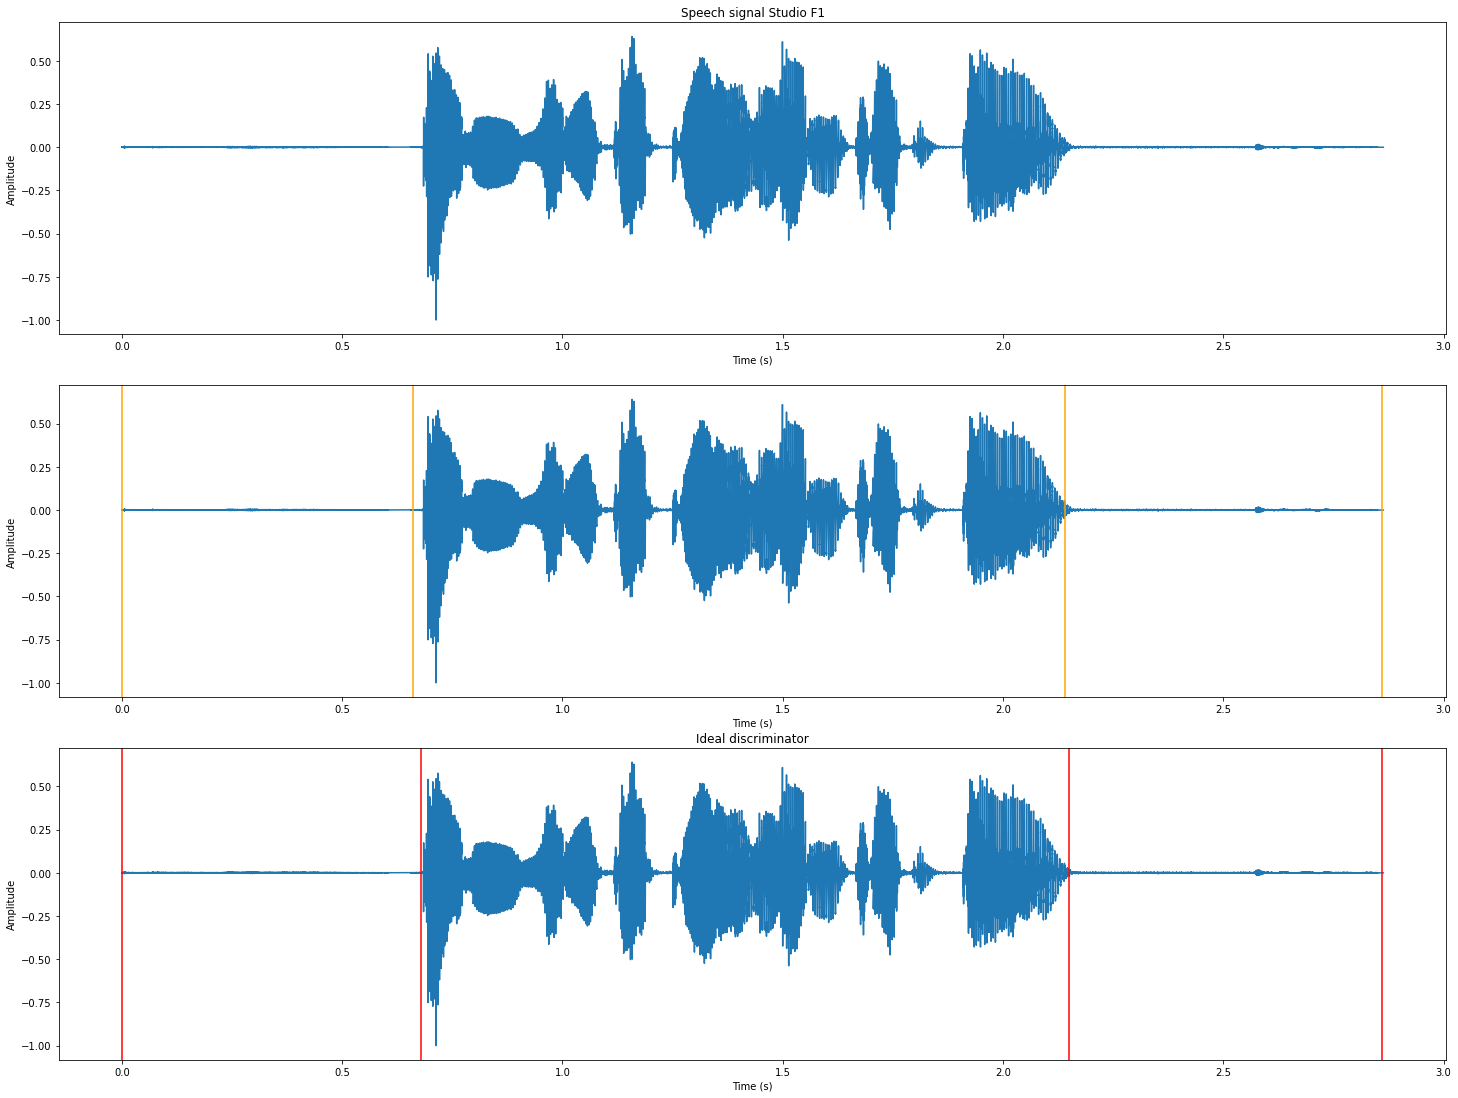

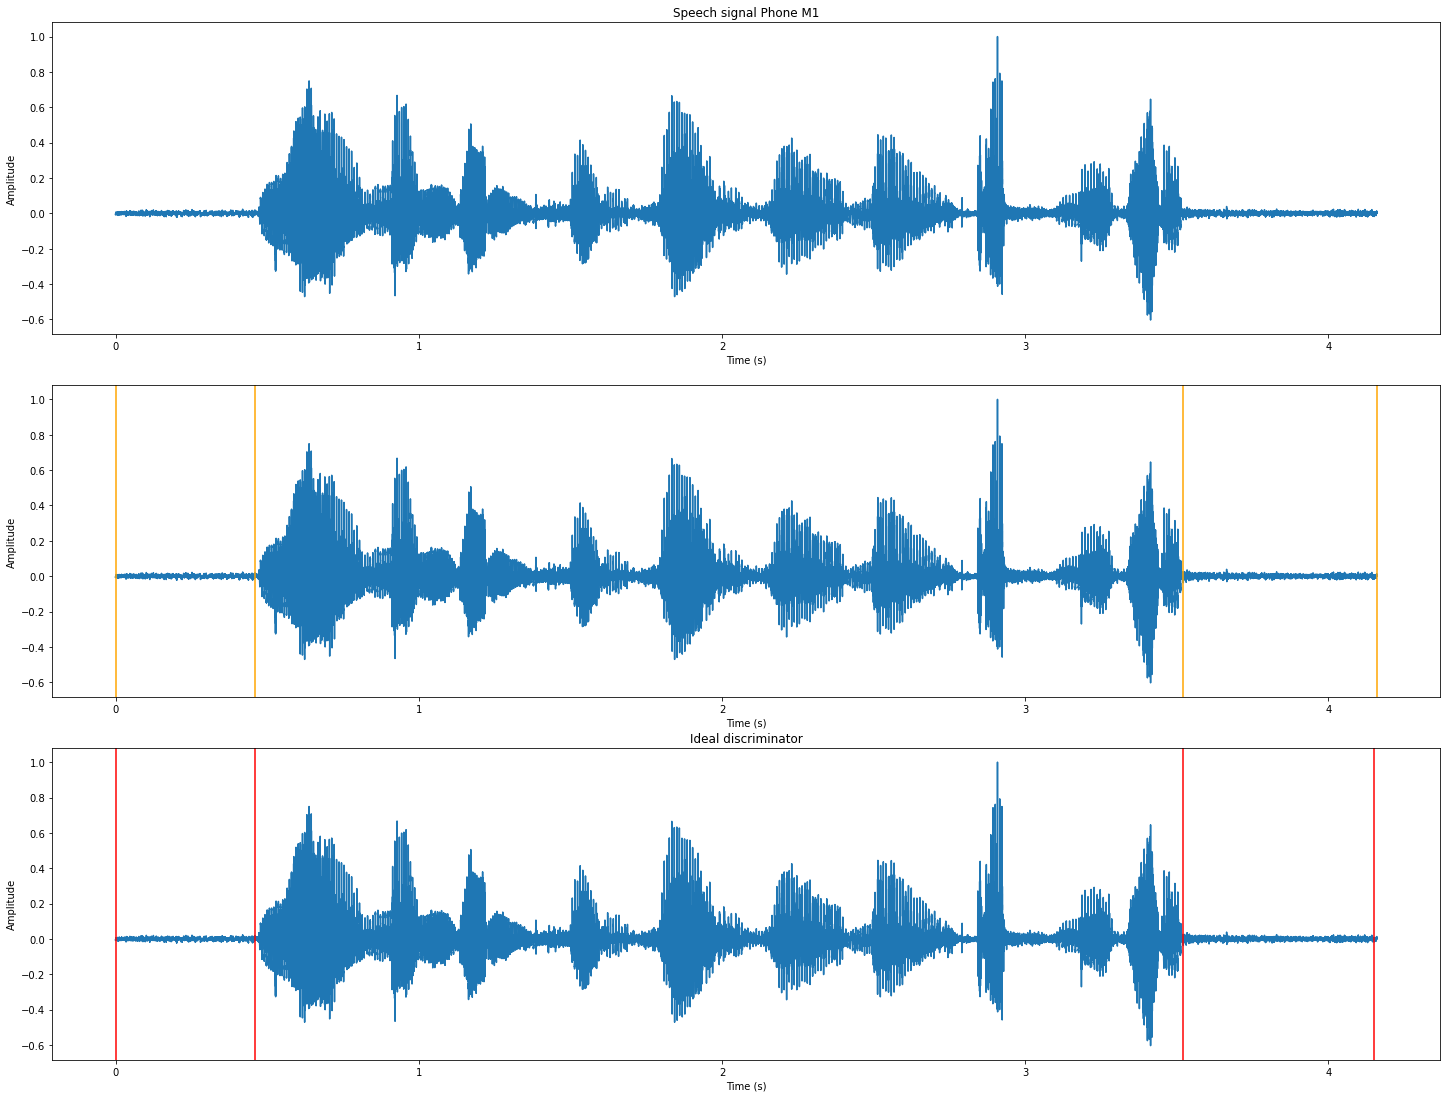

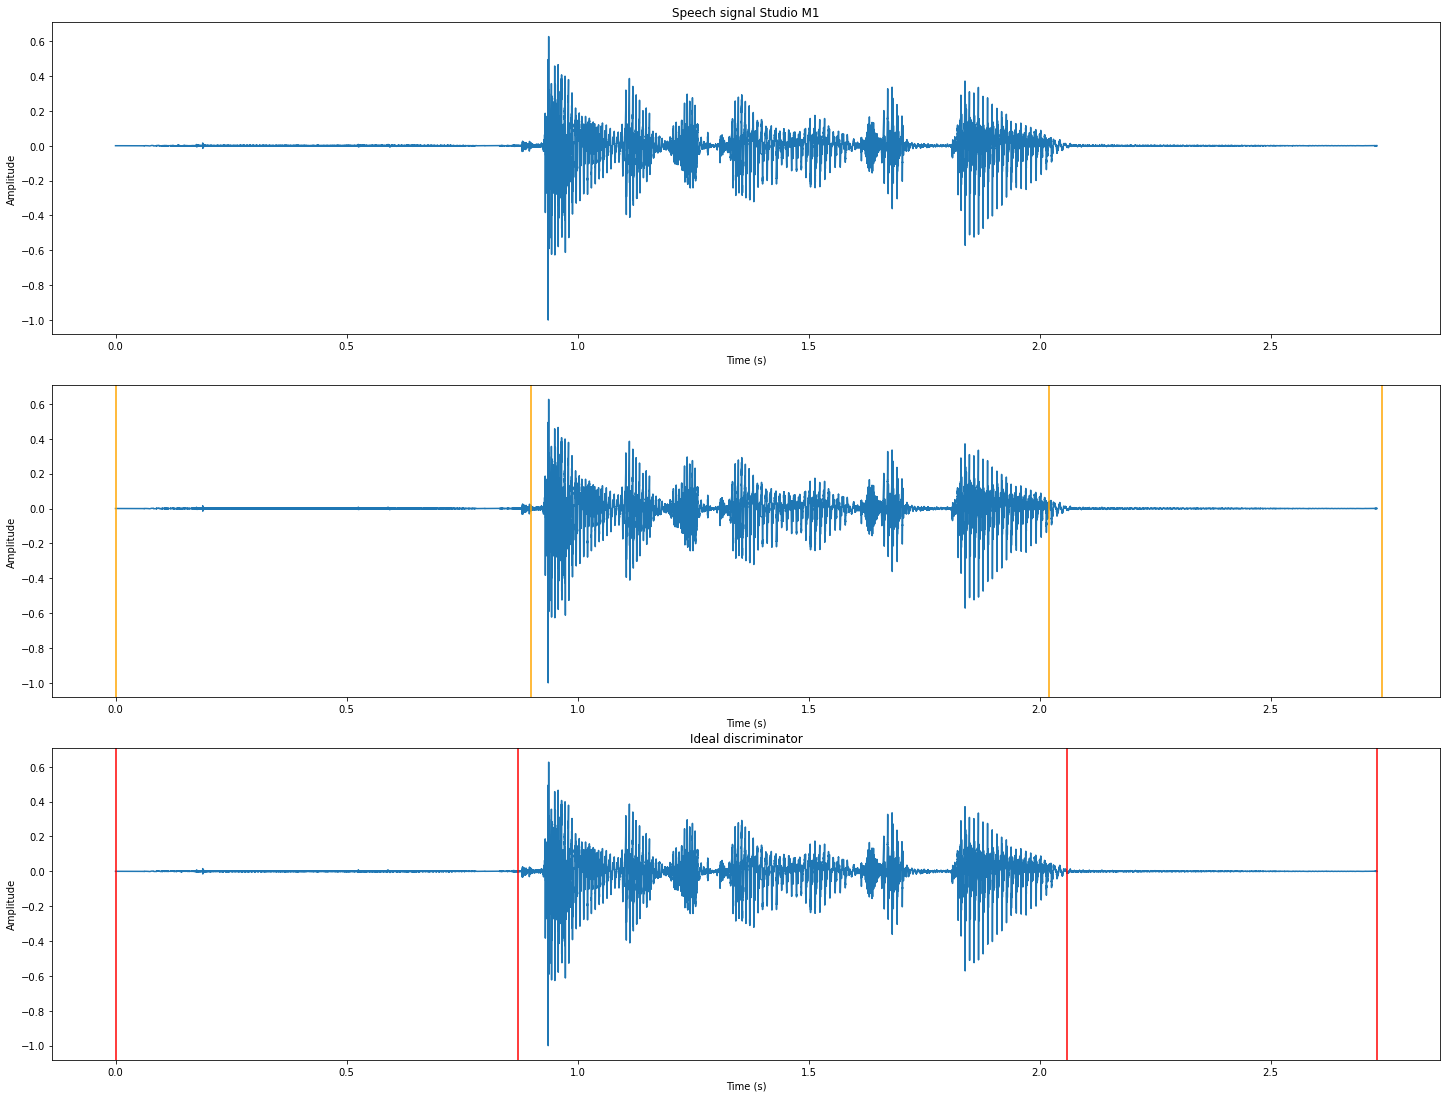

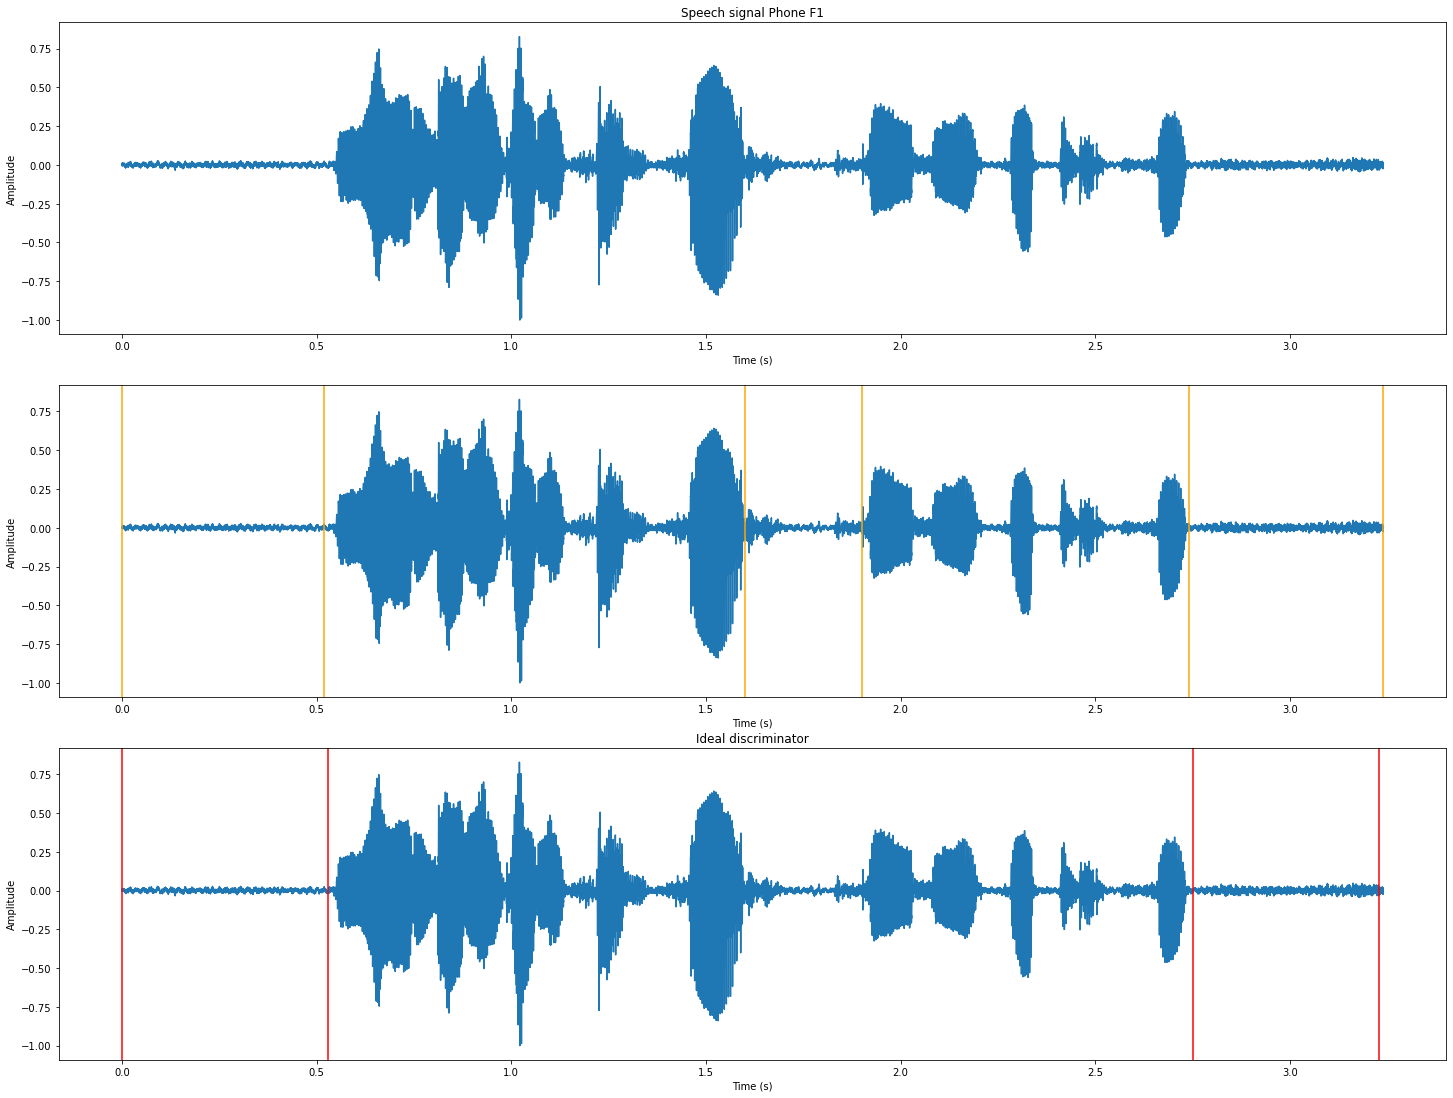

In [195]:
draw_result("TinHieuKiemThu/studio_F1.wav", "TinHieuKiemThu/studio_F1.lab", "Studio F1")
draw_result("TinHieuKiemThu/phone_M1.wav", "TinHieuKiemThu/phone_M1.lab", "Phone M1")
draw_result("TinHieuKiemThu/studio_M1.wav", "TinHieuKiemThu/studio_M1.lab", "Studio M1")
draw_result("TinHieuKiemThu/phone_F1.wav", "TinHieuKiemThu/phone_F1.lab", "Phone F1")